# 3D Visualizations for Toy Data

This notebook is for developing some fancy 3D visualizations of the toy data.

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Local imports
from toydata import (sample_track_params, gen_straight_tracks,
                     generate_data, track_hit_coords)

# Magic
%matplotlib notebook

Let's start with some 3D visualizations of a single track in my toy data

In [2]:
# Detector configuration
num_det_layers = 10
det_layer_size = 32
det_shape = (num_det_layers, det_layer_size, det_layer_size)

In [3]:
# Generate coordinates for a single track event
event, params = gen_straight_tracks(1, num_det_layers, det_layer_size)
event, params = event[0], params[0]
# Get the hit coordinates for this track
layer_idx = np.arange(num_det_layers)
x, y = track_hit_coords(params, layer_idx, as_type=np.float32)
xhits, yhits = x.astype(np.int), y.astype(np.int)

In [4]:
print(layer_idx)
print(xhits)
print(yhits)

[0 1 2 3 4 5 6 7 8 9]
[ 7  9 12 14 17 19 22 24 27 29]
[ 0  2  5  7  9 12 14 17 19 21]


<IPython.core.display.Javascript object>


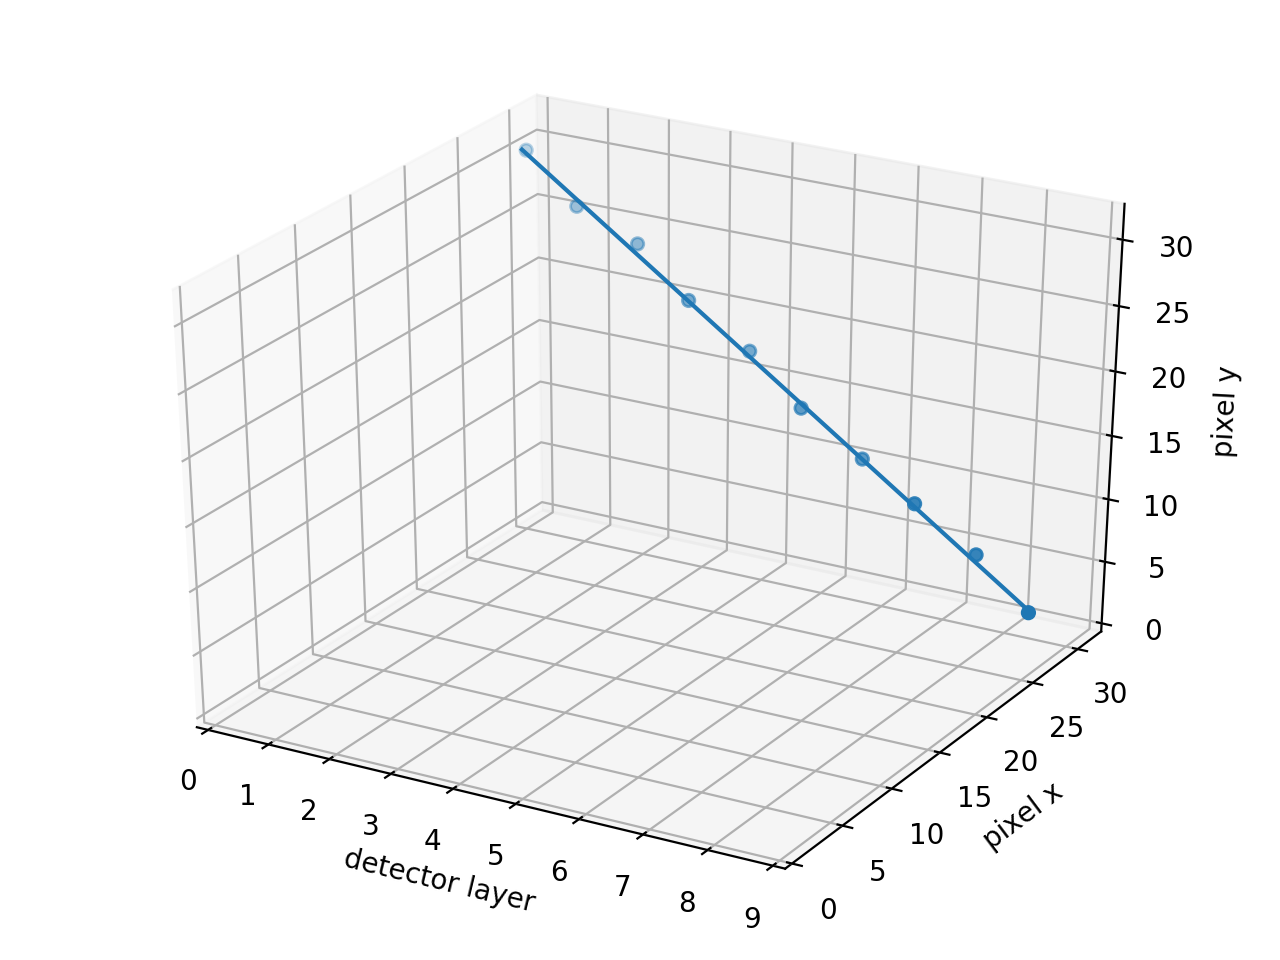

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(layer_idx, xhits+0.5, yhits+0.5)
ax.plot(layer_idx, x, y)
ax.set_xlim(0, num_det_layers-1)
ax.set_ylim(0, det_layer_size)
ax.set_zlim(0, det_layer_size)
ax.set_xlabel('detector layer')
ax.set_ylabel('pixel x')
ax.set_zlabel('pixel y')
plt.tight_layout();

Looks good. Now let's visualize a signal track amidst some background tracks.

In [6]:
# Generate an event with multiple tracks
data = generate_data((1,)+det_shape, noise_prob=0, avg_bkg_tracks=5, verbose=False)
event, sig_track, sig_param = data[0][0], data[1][0], data[2][0]

In [7]:
# Get the hit coordinates for the signal track
x, y = track_hit_coords(sig_param, layer_idx, as_type=np.float32)
xhits, yhits = x.astype(np.int), y.astype(np.int)

<IPython.core.display.Javascript object>


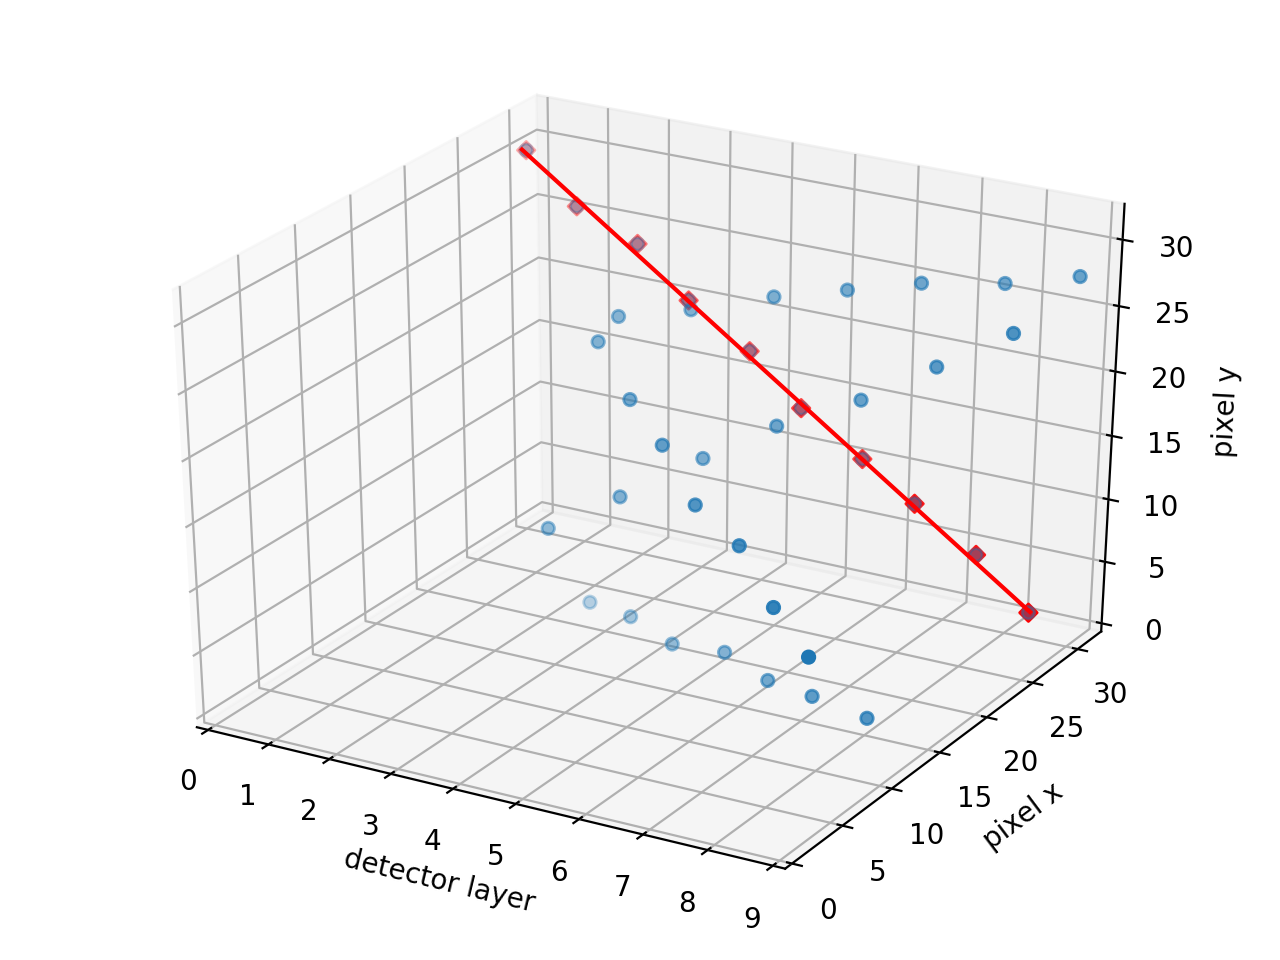

In [27]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
evhits = np.nonzero(event)
ax2.scatter(evhits[0], evhits[1]+0.5, evhits[2]+0.5)
ax2.scatter(layer_idx, xhits+0.5, yhits+0.5, c='r', marker='D')
ax2.plot(layer_idx, x, y, 'r')
ax2.set_xlim(0, num_det_layers-1)
ax2.set_ylim(0, det_layer_size)
ax2.set_zlim(0, det_layer_size)
ax2.set_xlabel('detector layer')
ax2.set_ylabel('pixel x')
ax2.set_zlabel('pixel y')
plt.tight_layout()

We want to somehow visualize this information plus a model's predictions on each detector plane. Let's first demonstrate the drawing of plane surfaces with colors.

<IPython.core.display.Javascript object>


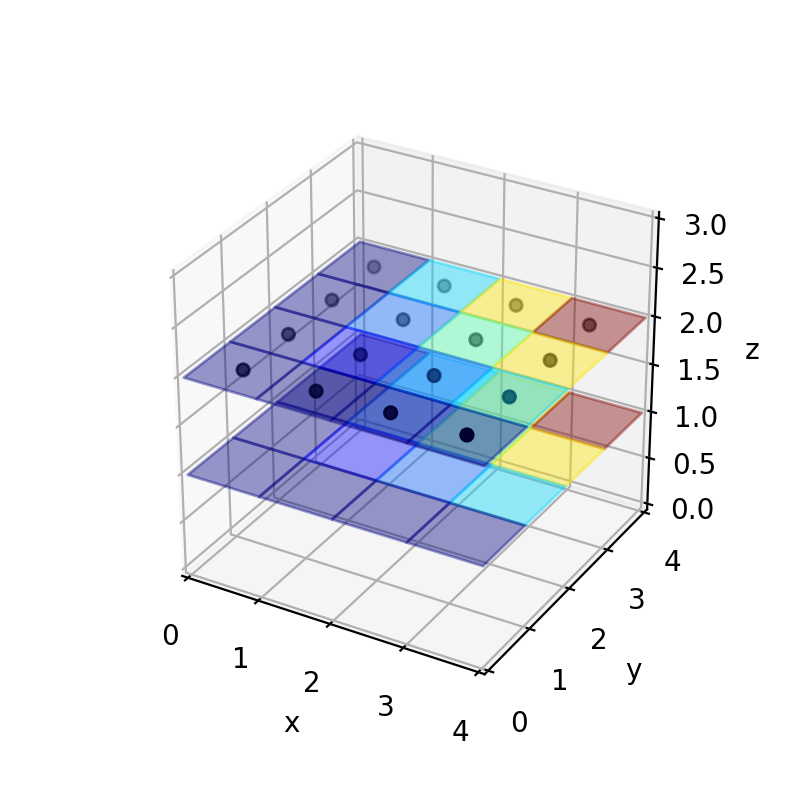

In [29]:
# Use a reduced size
size = 4
fig4 = plt.figure(figsize=(4,4))
ax4 = fig4.add_subplot(111, projection='3d')

# Grid coordinates of the plane, includes endpoints
p = np.arange(size+1)
px, py = np.meshgrid(p, p)
#print('px:')
#print(px)
#print('py:')
#print(py)

# Face colors
colors = (px*py)[:-1,:-1]
colors = colors / colors.max()
#print(colors)

# Draw the surfaces
ax4.plot_surface(px, py, 1, facecolors=cm.jet(colors),
                 rstride=1, cstride=1, shade=False, alpha=0.4)
ax4.plot_surface(px, py, 2, facecolors=cm.jet(colors),
                 rstride=1, cstride=1, shade=False, alpha=0.4)

# Draw center points
ax4.scatter(px[:-1,:-1]+0.5, py[:-1,:-1]+0.5, 2, c='k')

ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('z')
ax4.set_xlim(0, size)
ax4.set_ylim(0, size)
ax4.set_zlim(0, 3);

In [23]:
def draw_event_3d(event, sig_track=None, sig_params=None, prediction=None,
                  pred_threshold=0.1, pred_alpha=0.2,
                  color_map='rainbow'):
    """
    Draw 3D visualization of an event, a signal track, and a model prediction.
    """
    # Lookup the requested color map
    cmap = cm.get_cmap(color_map)

    # Setup the Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('detector layer')
    ax.set_ylabel('pixel x')
    ax.set_zlabel('pixel y')
    ax.set_xlim(0, event.shape[0]-1)
    ax.set_ylim(0, event.shape[1])
    ax.set_zlim(0, event.shape[2])

    # Draw the event hits
    if sig_track is not None:
        event = event - sig_track
    evhits = np.nonzero(event)
    ax.scatter(evhits[0], evhits[1]+0.5, evhits[2]+0.5)

    # Draw the signal track hits
    if sig_track is not None:
        sighits = np.nonzero(sig_track)
        ax.scatter(sighits[0], sighits[1]+0.5, sighits[2]+0.5,
                   c='r', marker='D')

    # Draw the signal track true intercepts
    if sig_params is not None:
        layer_idx = np.arange(event.shape[0])
        sigx, sigy = track_hit_coords(sig_params, layer_idx,
                                      as_type=np.float32)
        ax.plot(layer_idx, sigx, sigy, 'r')

    # Draw the predictions on each detector plane
    if prediction is not None:
        # Surface grid coordinates, including endpoints
        grid_idx = np.arange(event.shape[1]+1)
        gridx, gridy = np.meshgrid(grid_idx, grid_idx)
        for i in layer_idx:
            colors = cmap(prediction[i])
            # Set the global transparency of the prediction plane
            colors[:,:,3] = pred_alpha
            # Disable predictions below threshold
            colors[prediction[i] < pred_threshold,:] = 0.
            ax.plot_surface(i, gridx, gridy, rstride=1, cstride=1,
                            facecolors=colors, shade=False)
    plt.tight_layout()

def make_toy_pred(det_shape, sig_param):
    """Generate a dumb toy model output, just ~1/distance"""
    idx = tuple(map(np.arange, det_shape))
    pred = np.zeros(det_shape)
    # Track coordinates
    sigx, sigy = track_hit_coords(sig_param, idx[0], as_type=np.float32)
    px, py = np.meshgrid(idx[1], idx[2])
    for i in idx[0]:
        distance = np.sqrt((px + 0.5 - sigx[i])**2 + (py + 0.5 - sigy[i])**2)
        pred[i] = 1. / (distance + 0.1)
    return pred / pred.max()

In [21]:
pred = make_toy_pred(det_shape, sig_param)

<IPython.core.display.Javascript object>


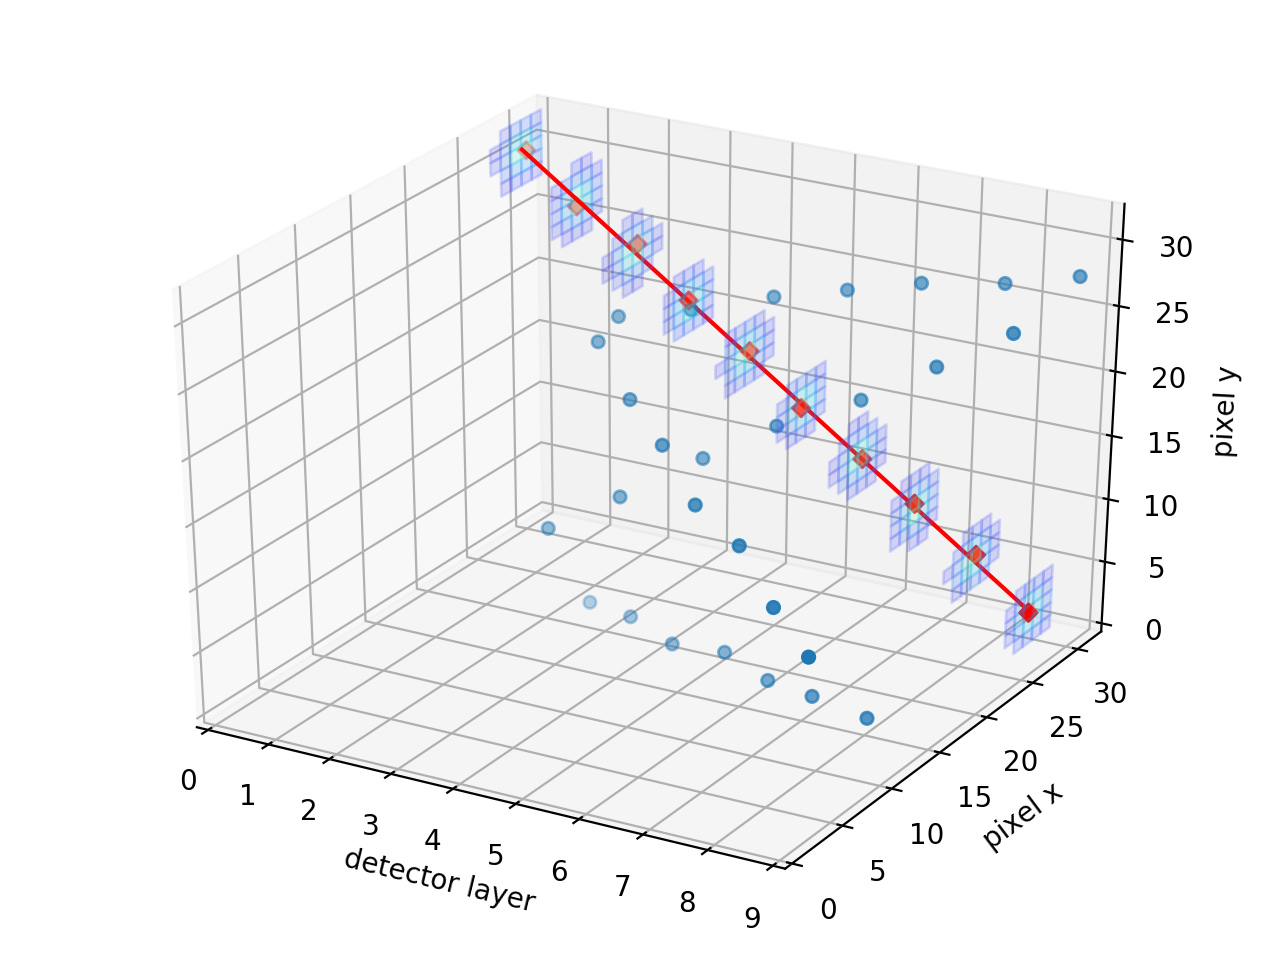

In [22]:
draw_event_3d(event, sig_track, sig_param, pred)

## Discussion

This plot looks really nice! Now I can incorporate this into my model notebooks to visualize the networks' predictions.

I will move the draw function into the drawing module, but keep this version here for possible later testing/development.